In [19]:
import sys
sys.path.append('..')

import mne
from ssvep import SSVEP
from ssvep import SSVEPCovariances
from ssvep.example_data import epoch_example

from genbci.util import plot_snr, plot_psd, plot_tfr, get_exo_data

import matplotlib.pyplot as plt

import numpy as np

In [20]:
epochs_exo = get_exo_data("/Users/daniele/Desktop/thesis/library/genbci/ssvep/data/dataset-ssvep-exoskeleton", plot=False)

Opening raw data file /Users/daniele/Desktop/thesis/library/genbci/ssvep/data/dataset-ssvep-exoskeleton/./subject12/record-[2014.03.10-19.47.49]_raw.fif...
Isotrak not found
    Range : 0 ... 90527 =      0.000 ...   353.621 secs
Ready.
Reading 0 ... 90527  =      0.000 ...   353.621 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 30.00 Hz: -6.02, -6.02 dB



In [23]:
ssvep_example = SSVEP(epochs_exo, [13.0, 17.0, 21.0], fmin=0.5, fmax=30, compute_tfr=True)
y = ssvep_example.epochs.events[:,2]
classes = ssvep_example.epochs.event_id.values()

Using multitaper spectrum estimation with 7 DPSS windows


In [24]:
sscov_trials = SSVEPCovariances(estimator='lwf', freq_targets=[13, 17, 21],
                              filttype='forward-backward').transform(ssvep_example.epochs.get_data())

In [25]:
from sklearn.model_selection import train_test_split
cov_train, cov_test, y_train, y_test = train_test_split(sscov_trials, y, test_size=0.2, random_state=42)

In [26]:
from pyriemann.utils.mean import mean_riemann
cov_centers = np.empty((len(classes), 24, 24))
for i, l in enumerate(classes):
    cov_centers[i, :, :] = mean_riemann(cov_train[y_train == l, :, :])

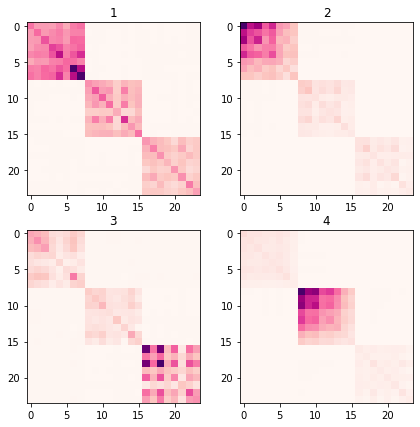

In [27]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(cov_centers[i, :, :], cmap=plt.get_cmap('RdPu'), interpolation='nearest')
    _ = plt.title(l)

In [30]:
from pyriemann.utils.distance import distance_riemann
accuracy = list()
for sample, true_label in zip(cov_test, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(len(classes))]
    if list(classes)[np.array(dist).argmin()] == true_label:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*np.array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)

Evaluation accuracy on test set is 85.71%


In [12]:
import pyriemann
from sklearn.model_selection import cross_val_score

mdm = pyriemann.classification.MDM()

accuracy = cross_val_score(mdm, sscov_trials, ssvep_example.epochs.events[:,2])

print(accuracy)

[0.57142857 0.85714286 0.83333333 0.5        0.33333333]


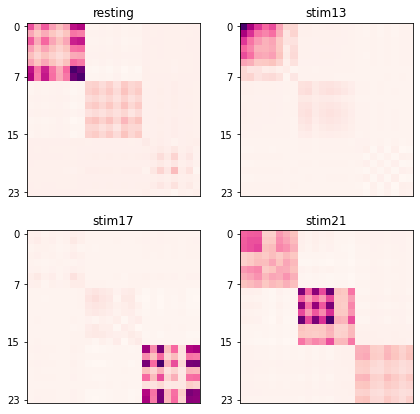

In [60]:
plt.figure(figsize=(7, 7))
inv_map = {v-1: k for k, v in ssvep_example.epochs.event_id.items()}

for i, l in enumerate(ssvep_example.epochs.event_id.values()):
    plt.subplot(2, 2, i+1)
    plt.imshow(sscov_trials[ssvep_example.epochs.events[:,2] == l, :, :][0, :, :], cmap=plt.get_cmap('RdPu'), interpolation="nearest")
    plt.xticks([])
    plt.yticks([0, 7, 15, 23])

    _ = plt.title(inv_map[i])

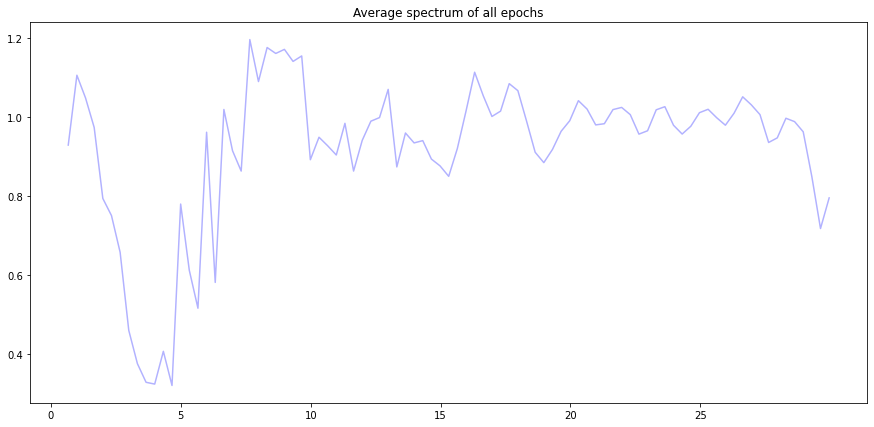

In [4]:
plot_snr(ssvep_example.get_snr(), ssvep_example.frequencies)

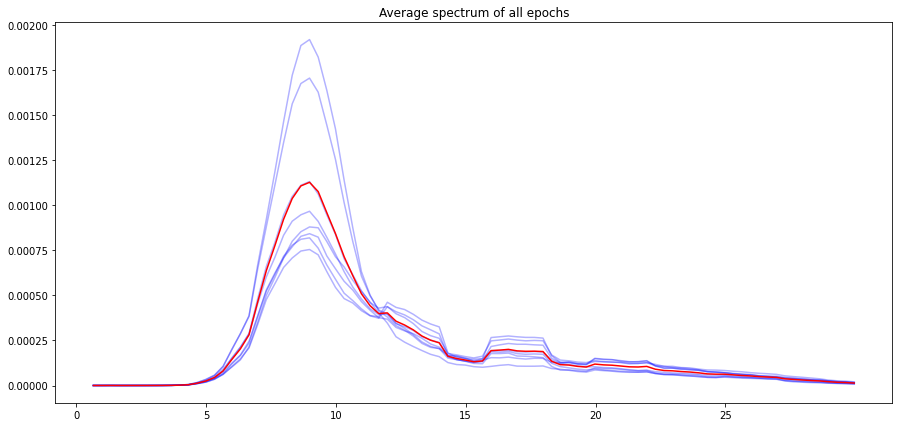

In [5]:
plot_psd(ssvep_example.psd, ssvep_example.frequencies)

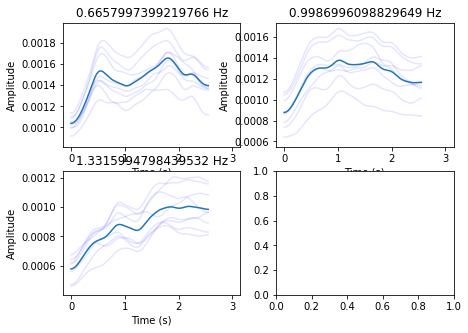

In [6]:
plot_tfr(ssvep_example.stimulation.tfr, ssvep_example.frequencies, ssvep_example.info["sfreq"])